### Loading Libraries and Dataset

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

ap = pd.read_csv("../data/flights.csv")
ap.head()

FL_DATE  OP_CARRIER_AIRLINE_ID TAIL_NUM  OP_CARRIER_FL_NUM  \
0  2017-08-01                  19805   N871AA               1150   
1  2017-08-01                  19805   N008AA               1152   
2  2017-08-01                  19805   N5FPAA               1153   
3  2017-08-01                  19805   N5FPAA               1153   
4  2017-08-01                  19805   N3GPAA               1155   

   ORIGIN_AIRPORT_ID ORIGIN  DEST_AIRPORT_ID DEST  CRS_DEP_TIME  DEP_TIME  \
0              11298    DFW            12953  LGA           635     628.0   
1              11298    DFW            12441  JAC          1830    1827.0   
2              11057    CLT            15024  STT          1150    1144.0   
3              12478    JFK            11057  CLT           815     909.0   
4              12892    LAX            12889  LAS          1400    1411.0   

   ...  CRS_ELAPSED_TIME  ACTUAL_ELAPSED_TIME  FLIGHTS  DISTANCE  \
0  ...             206.0                190.0      1.0    1389.0   
1  ...             168.0                167.0      1.0    1047.0   
2  ...             233.0                251.0      1.0    1520.0   
3  ...             126.0                102.0      1.0     541.0   
4  ...              83.0                 72.0      1.0     236.0   

   CARRIER_DELAY  WEATHER_DELAY  NAS_DELAY  SECURITY_DELAY  \
0            NaN            NaN        NaN             NaN   
1            NaN            NaN        NaN             NaN   
2            NaN            NaN        NaN             NaN   
3           30.0            0.0        0.0             0.0   
4            NaN            NaN        NaN             NaN   

   LATE_AIRCRAFT_DELAY  Unnamed: 26  
0                  NaN          NaN  
1                  NaN          NaN  
2                  NaN          NaN  
3                  0.0          NaN  
4                  NaN          NaN  

[5 rows x 27 columns]

### EDA 1 - Number of Flights by Arrival Performance

National flight data in August 2018

Total Number of Flights: 701352
- Arrived Earlier: 469586 (66.95%)
- Delayed: 194395 (27.72%)
- On Time: 20857 (2.97%)


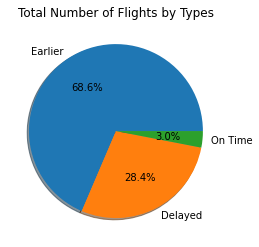

In [6]:
tot_fn = len(ap)
tot_ft_sch = ap.CRS_ELAPSED_TIME.sum()
tot_ft_act = ap.ACTUAL_ELAPSED_TIME.sum()
tot_fn_early = len(ap[ap['CRS_ELAPSED_TIME'] > ap['ACTUAL_ELAPSED_TIME']])
tot_fn_delayed = len(ap[ap['CRS_ELAPSED_TIME'] < ap['ACTUAL_ELAPSED_TIME']])
tot_fn_ontime = len(ap[ap['CRS_ELAPSED_TIME'] == ap['ACTUAL_ELAPSED_TIME']])

print("National flight data in August 2018")
print()
print("Total Number of Flights:", tot_fn)
print("- Arrived Earlier: {} ({}%)".format(tot_fn_early, round(tot_fn_early/tot_fn * 100, 2)))
print("- Delayed: {} ({}%)".format(tot_fn_delayed, round(tot_fn_delayed/tot_fn * 100, 2)))
print("- On Time: {} ({}%)".format(tot_fn_ontime, round(tot_fn_ontime/tot_fn * 100, 2)))

plt.pie(x=[tot_fn_early, tot_fn_delayed, tot_fn_ontime], 
        labels=['Earlier', 'Delayed', 'On Time'], shadow=True, autopct='%1.1f%%')
plt.title("Total Number of Flights by Types")
plt.show()

### EDA 2 - Total Flight Time by Arrival Performance

Total Flight Time (Scheduled): 95972717.0 minutes
Total Flight Time (Actual): 91277564.0 minutes
- Arrived Earlier: 59821047.0 minutes (65.54%)
- Delayed: 28874427.0 minutes (31.63%)
- On Time: 2582090.0 minutes (2.83%)


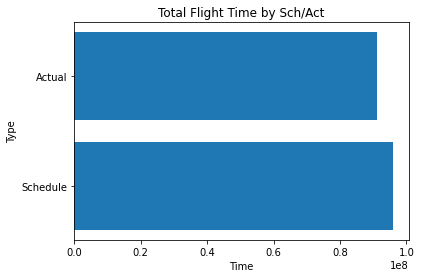

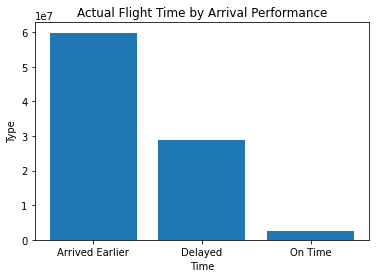

In [8]:
act_early_sum = ap[ap['CRS_ELAPSED_TIME'] > ap['ACTUAL_ELAPSED_TIME']]['ACTUAL_ELAPSED_TIME'].sum()
act_delayed_sum = ap[ap['CRS_ELAPSED_TIME'] < ap['ACTUAL_ELAPSED_TIME']]['ACTUAL_ELAPSED_TIME'].sum()
act_ontime_sum = ap[ap['CRS_ELAPSED_TIME'] == ap['ACTUAL_ELAPSED_TIME']]['ACTUAL_ELAPSED_TIME'].sum()

print("Total Flight Time (Scheduled): {} minutes".format(tot_ft_sch))
print("Total Flight Time (Actual): {} minutes".format(tot_ft_act))
print("- Arrived Earlier: {} minutes ({}%)".format(act_early_sum, round(act_early_sum/tot_ft_act * 100, 2)))
print("- Delayed: {} minutes ({}%)".format(act_delayed_sum, round(act_delayed_sum/tot_ft_act * 100, 2)))
print("- On Time: {} minutes ({}%)".format(act_ontime_sum, round(act_ontime_sum/tot_ft_act * 100, 2)))

ft_by_type = pd.DataFrame({"Type":["Schedule", "Actual"],
                          "Time":[tot_ft_sch, tot_ft_act]})

act_time_by_type = pd.DataFrame({"Type":["Arrived Earlier", "Delayed", "On Time"], 
                                 "Time":[act_early_sum, act_delayed_sum, act_ontime_sum]})

plt.barh(ft_by_type['Type'], ft_by_type['Time'])
plt.xlabel("Time")
plt.ylabel("Type")
plt.title("Total Flight Time by Sch/Act")
plt.show()

plt.bar(act_time_by_type['Type'], act_time_by_type['Time'])
plt.xlabel("Time")
plt.ylabel("Type")
plt.title("Actual Flight Time by Arrival Performance")
plt.show()

### EDA 3 - Total Delay Time by Types

            Delay_Type  Tot_Time
4  LATE_AIRCRAFT_DELAY   4568704
0        CARRIER_DELAY   3083348
2            NAS_DELAY   3015544
1        WEATHER_DELAY    633603
3       SECURITY_DELAY     12045


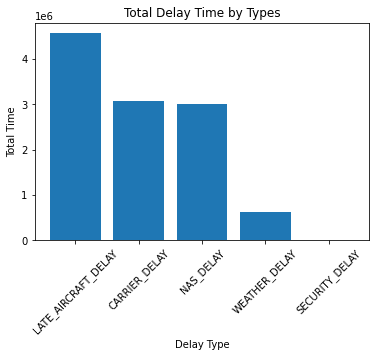

In [9]:
delayed_by_type = pd.DataFrame(ap.iloc[:,-6:-1].sum(axis='rows')).reset_index()
delayed_by_type.columns = ['Delay_Type', 'Tot_Time']
delayed_by_type['Tot_Time'] = delayed_by_type['Tot_Time'].astype('int')
delayed_by_type = delayed_by_type.sort_values(by='Tot_Time', ascending=False)
print(delayed_by_type)

plt.bar(delayed_by_type['Delay_Type'], height=delayed_by_type['Tot_Time'])
plt.xlabel("Delay Type")
plt.ylabel("Total Time")
plt.title("Total Delay Time by Types")
plt.xticks(rotation=45)
plt.show()

### EDA 4 - Trend of Total Delay Time

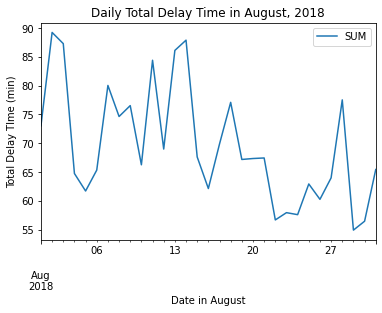

In [10]:
date_delay = pd.DataFrame(ap.iloc[:, 0])
delay_type_temp = pd.DataFrame(ap.iloc[:,-6:-1])

date_delay = pd.concat([date_delay, delay_type_temp], axis='columns')
date_delay['FL_DATE'] = pd.to_datetime(date_delay['FL_DATE'])

date_delay = pd.DataFrame(date_delay.resample('D', on='FL_DATE')[['LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY', 
                                        'NAS_DELAY', 'WEATHER_DELAY', 'SECURITY_DELAY']].mean()).reset_index()

delay_type_sum = date_delay.iloc[:,1:6].sum(axis='columns')

date_delay = pd.concat([date_delay, delay_type_sum], axis='columns')
date_delay.columns = ['FL_DATE', 'LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY', 'NAS_DELAY', 'WEATHER_DELAY', 'SECURITY_DELAY', 'SUM']
date_delay

date_delay.plot(x='FL_DATE', y=['SUM'])
plt.xlabel("Date in August")
plt.ylabel("Total Delay TIme (min)")
plt.title("Daily Total Delay Time in August, 2018")
plt.show()

### EDA 5 - Identifying Flight Information with Abnormal Delay Time

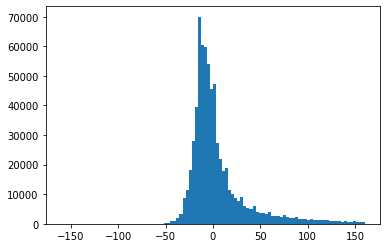

Total Observation: 684505
Mean: 10.08
Std 53.59
Index(['FL_DATE', 'ORIGIN', 'DEST', 'ARR_DELAY'], dtype='object')


In [14]:
# Distribution of Delays

delay_all = ap[['FL_DATE', 'ORIGIN', 'DEST', 'ARR_DELAY']].dropna()
d_mean = round(np.mean(delay_all['ARR_DELAY']), 2)
d_std = round(np.std(delay_all['ARR_DELAY']), 2)
plt.hist(delay_all['ARR_DELAY'], bins=100, range=(-3*d_std, 3*d_std))
plt.show()

print("Total Observation:", len(delay_all))
print("Mean:", d_mean)
print("Std", d_std)

# for i in range(len(delay_all)):
#     if delay_all.iloc[i, 3] > 3*d_std:
#         delay_all["RANGE"] = "outlier_up"
#     elif delay_all.iloc[i, 3] > -3*d_std:
#         delay_all["RANGE"] = "outlier_down"
#     else:
#         delay_all["RANGE"] = "normal"

print(delay_all.columns)

### EDA 6 - Total Number of Cancellation by Types

  CCL_code  Counts
0        C    7056
1        B    3762
2        A    3452


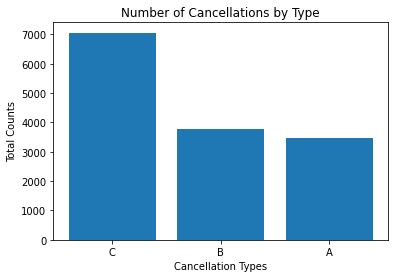

In [16]:
ccl_by_type = pd.DataFrame(ap.CANCELLATION_CODE.value_counts()).reset_index()
ccl_by_type.columns = ['CCL_code', 'Counts']

print(ccl_by_type)

plt.bar(ccl_by_type['CCL_code'], height=ccl_by_type['Counts'])
plt.xlabel("Cancellation Types")
plt.ylabel("Total Counts")
plt.title("Number of Cancellations by Type")
plt.show()

### Building Graphs

In [18]:
## Using Names of the airports
df = ap[["ORIGIN", "DEST", "CRS_ELAPSED_TIME"]]
df2 = pd.DataFrame(df.groupby(["ORIGIN", "DEST"])["CRS_ELAPSED_TIME"].mean()).reset_index()
df2.columns = ["ORIGIN", "DEST", "MEAN_ELAPSED_TIME"]
df2["MEAN_ELAPSED_TIME"] = round(df2["MEAN_ELAPSED_TIME"], 2)

df_temp = pd.DataFrame(df.groupby(["ORIGIN", "DEST"]).count()).reset_index()
df_temp.columns = ["ORIGIN", "DEST", "NUM_TRAVEL"]
df2["NUM_TRAVEL"] = df_temp["NUM_TRAVEL"]
df2


df2.to_csv("../data/airport.csv")

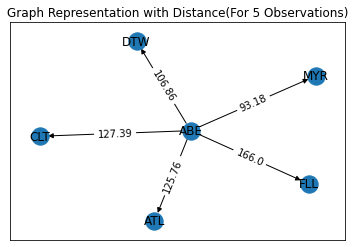

In [25]:
df_first_5 = df2.iloc[:5,:]

G_dist = nx.from_pandas_edgelist(df_first_5, "ORIGIN", "DEST", "MEAN_ELAPSED_TIME", create_using=nx.DiGraph())

# fig = plt.gcf()
# fig.set_size_inches(100, 100)

pos_dist = nx.spring_layout(G_dist)
nx.draw_networkx(G_dist, pos_dist, with_labels=True)
labels_dist = nx.get_edge_attributes(G_dist, 'MEAN_ELAPSED_TIME')
nx.draw_networkx_edge_labels(G_dist, pos_dist, edge_labels=labels_dist)
plt.title("Graph Representation with Distance(For 5 Observations)")
plt.show()

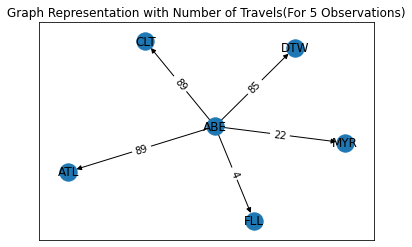

In [26]:
G_freq = nx.from_pandas_edgelist(df_first_5, "ORIGIN", "DEST", "NUM_TRAVEL", create_using=nx.DiGraph())

# fig = plt.gcf()
# fig.set_size_inches(100, 100)

pos_freq = nx.spring_layout(G_freq)
nx.draw_networkx(G_freq, pos_freq, with_labels=True)
labels_freq = nx.get_edge_attributes(G_freq, 'NUM_TRAVEL')
nx.draw_networkx_edge_labels(G_freq, pos_freq, edge_labels=labels_freq)
plt.title("Graph Representation with Number of Travels(For 5 Observations)")
plt.show()

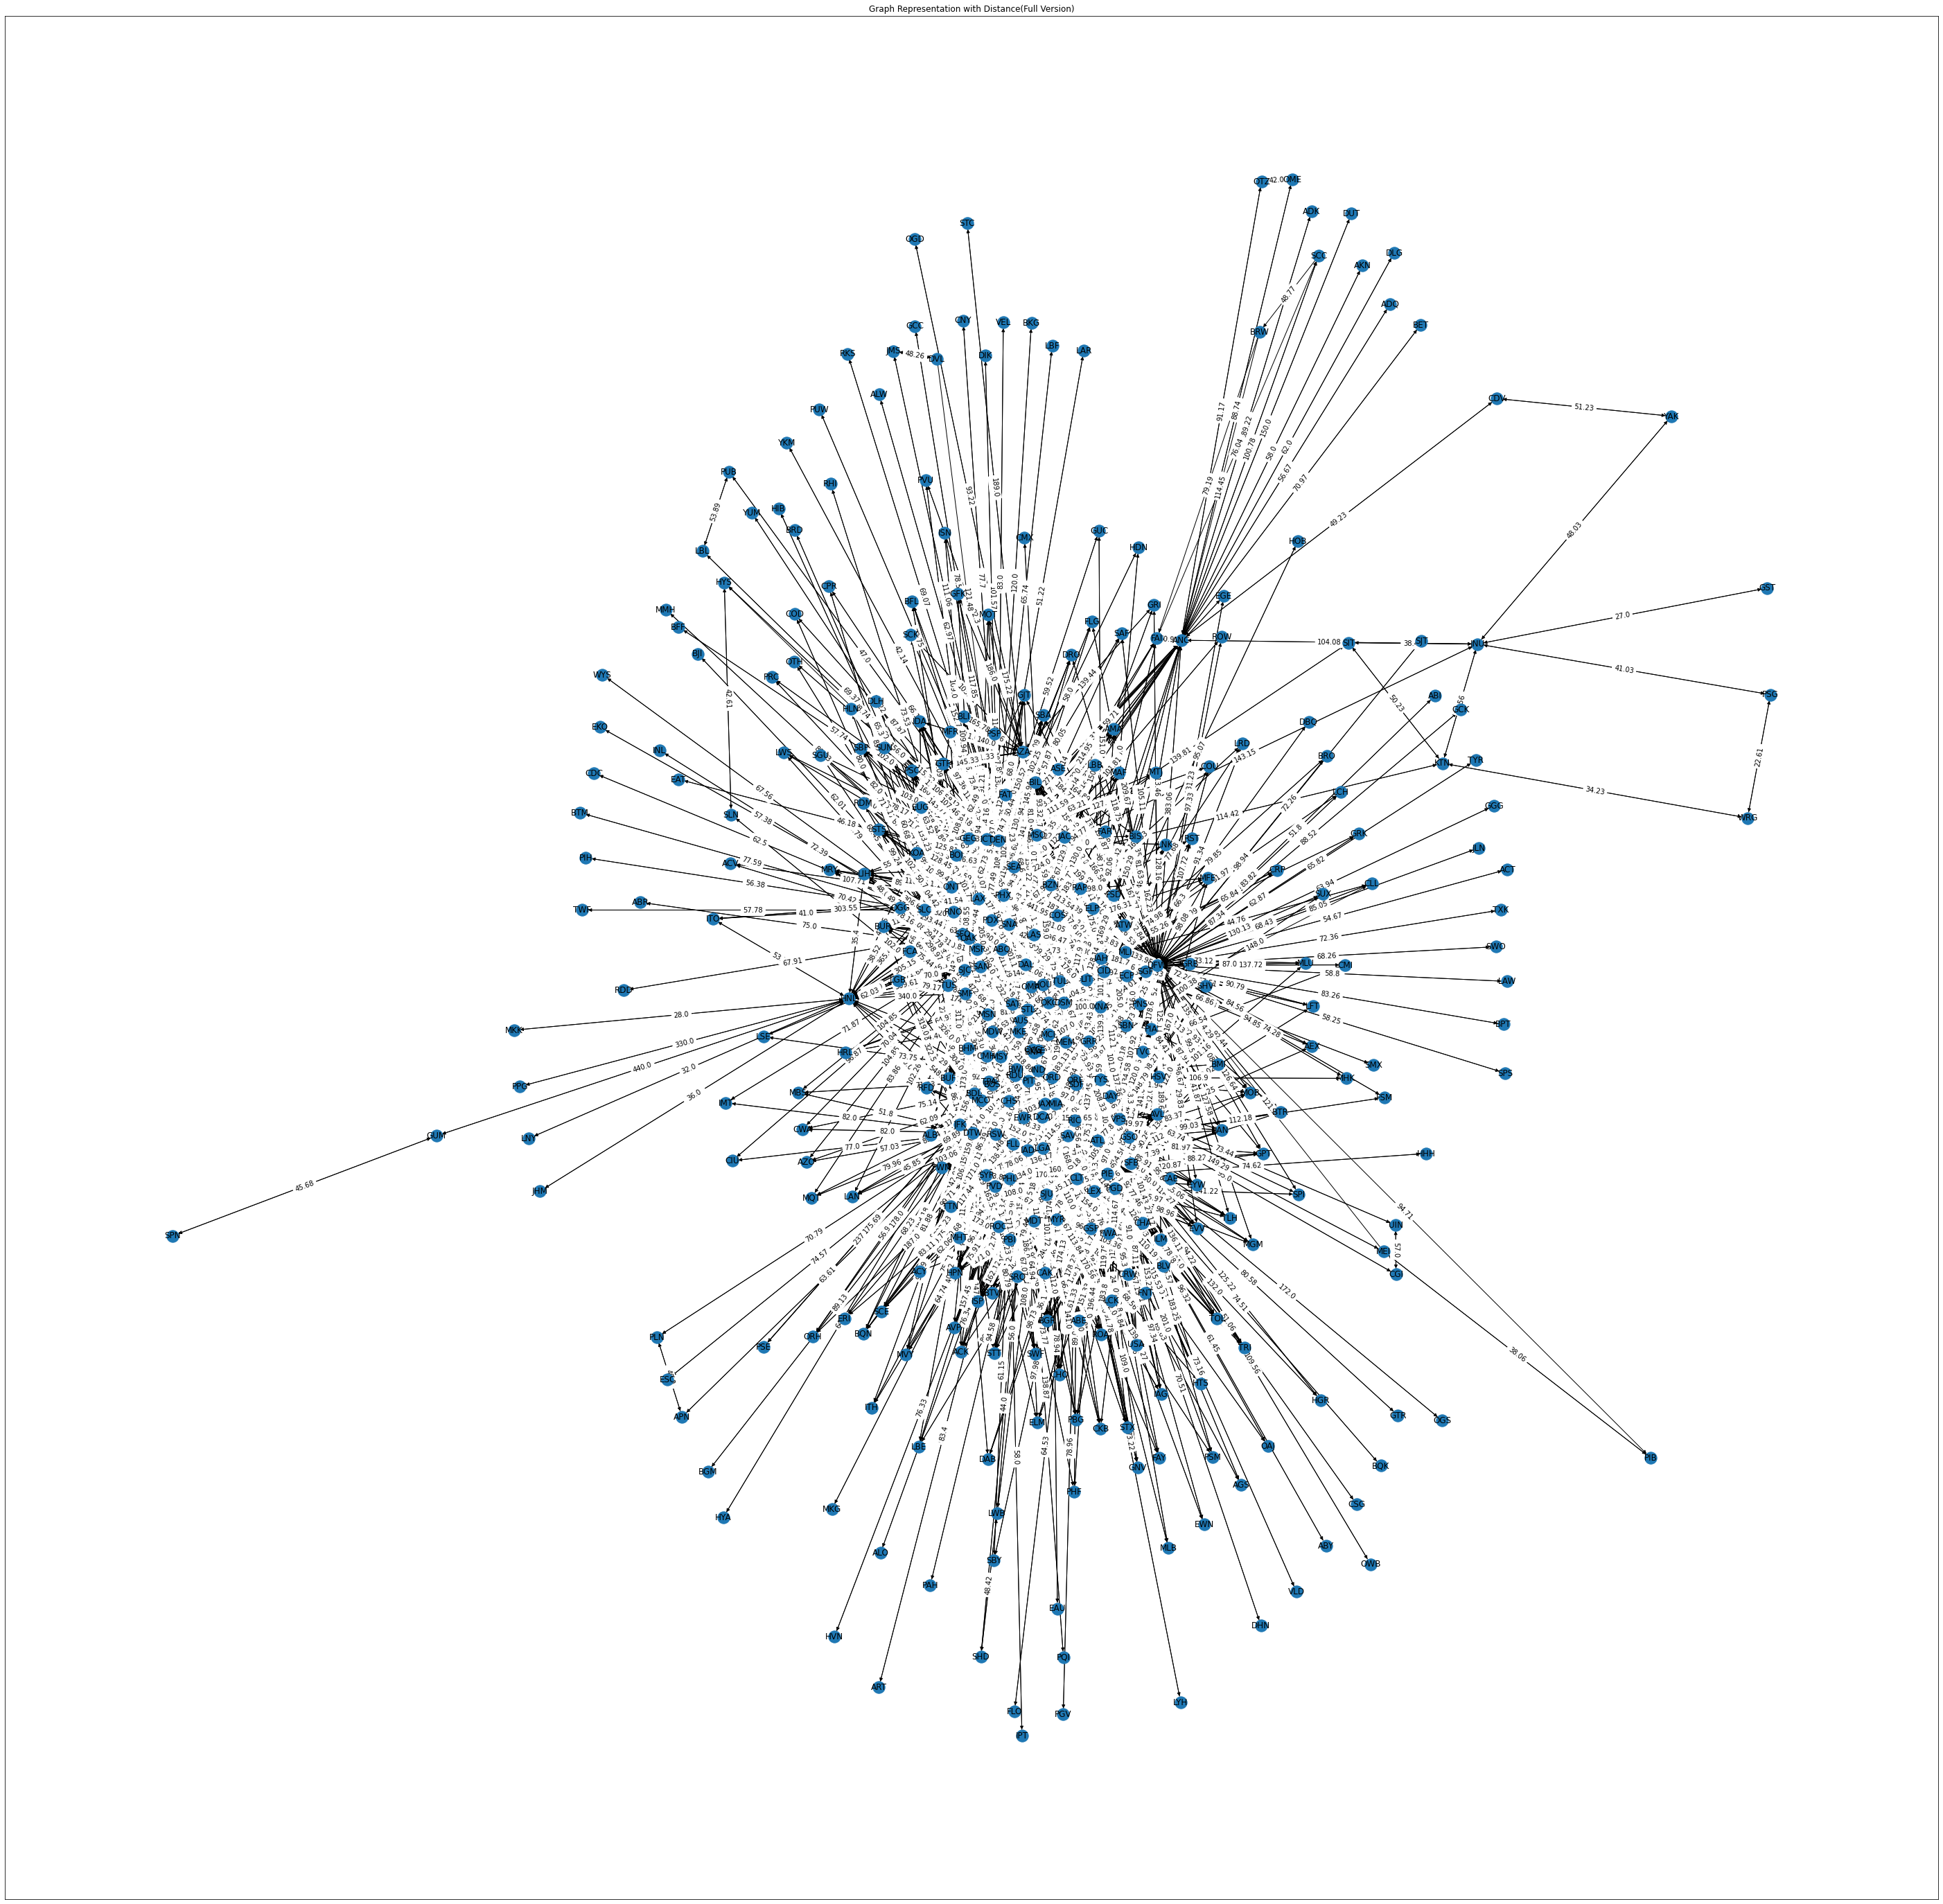

In [27]:
G2 = nx.from_pandas_edgelist(df2, "ORIGIN", "DEST", "MEAN_ELAPSED_TIME", create_using=nx.DiGraph())

fig = plt.gcf()
fig.set_size_inches(50, 50)

pos2 = nx.spring_layout(G2)
nx.draw_networkx(G2, pos2, with_labels=True)
labels2 = nx.get_edge_attributes(G2, 'MEAN_ELAPSED_TIME')
nx.draw_networkx_edge_labels(G2, pos2, edge_labels=labels2)
plt.title("Graph Representation with Distance(Full Version)")
plt.show()

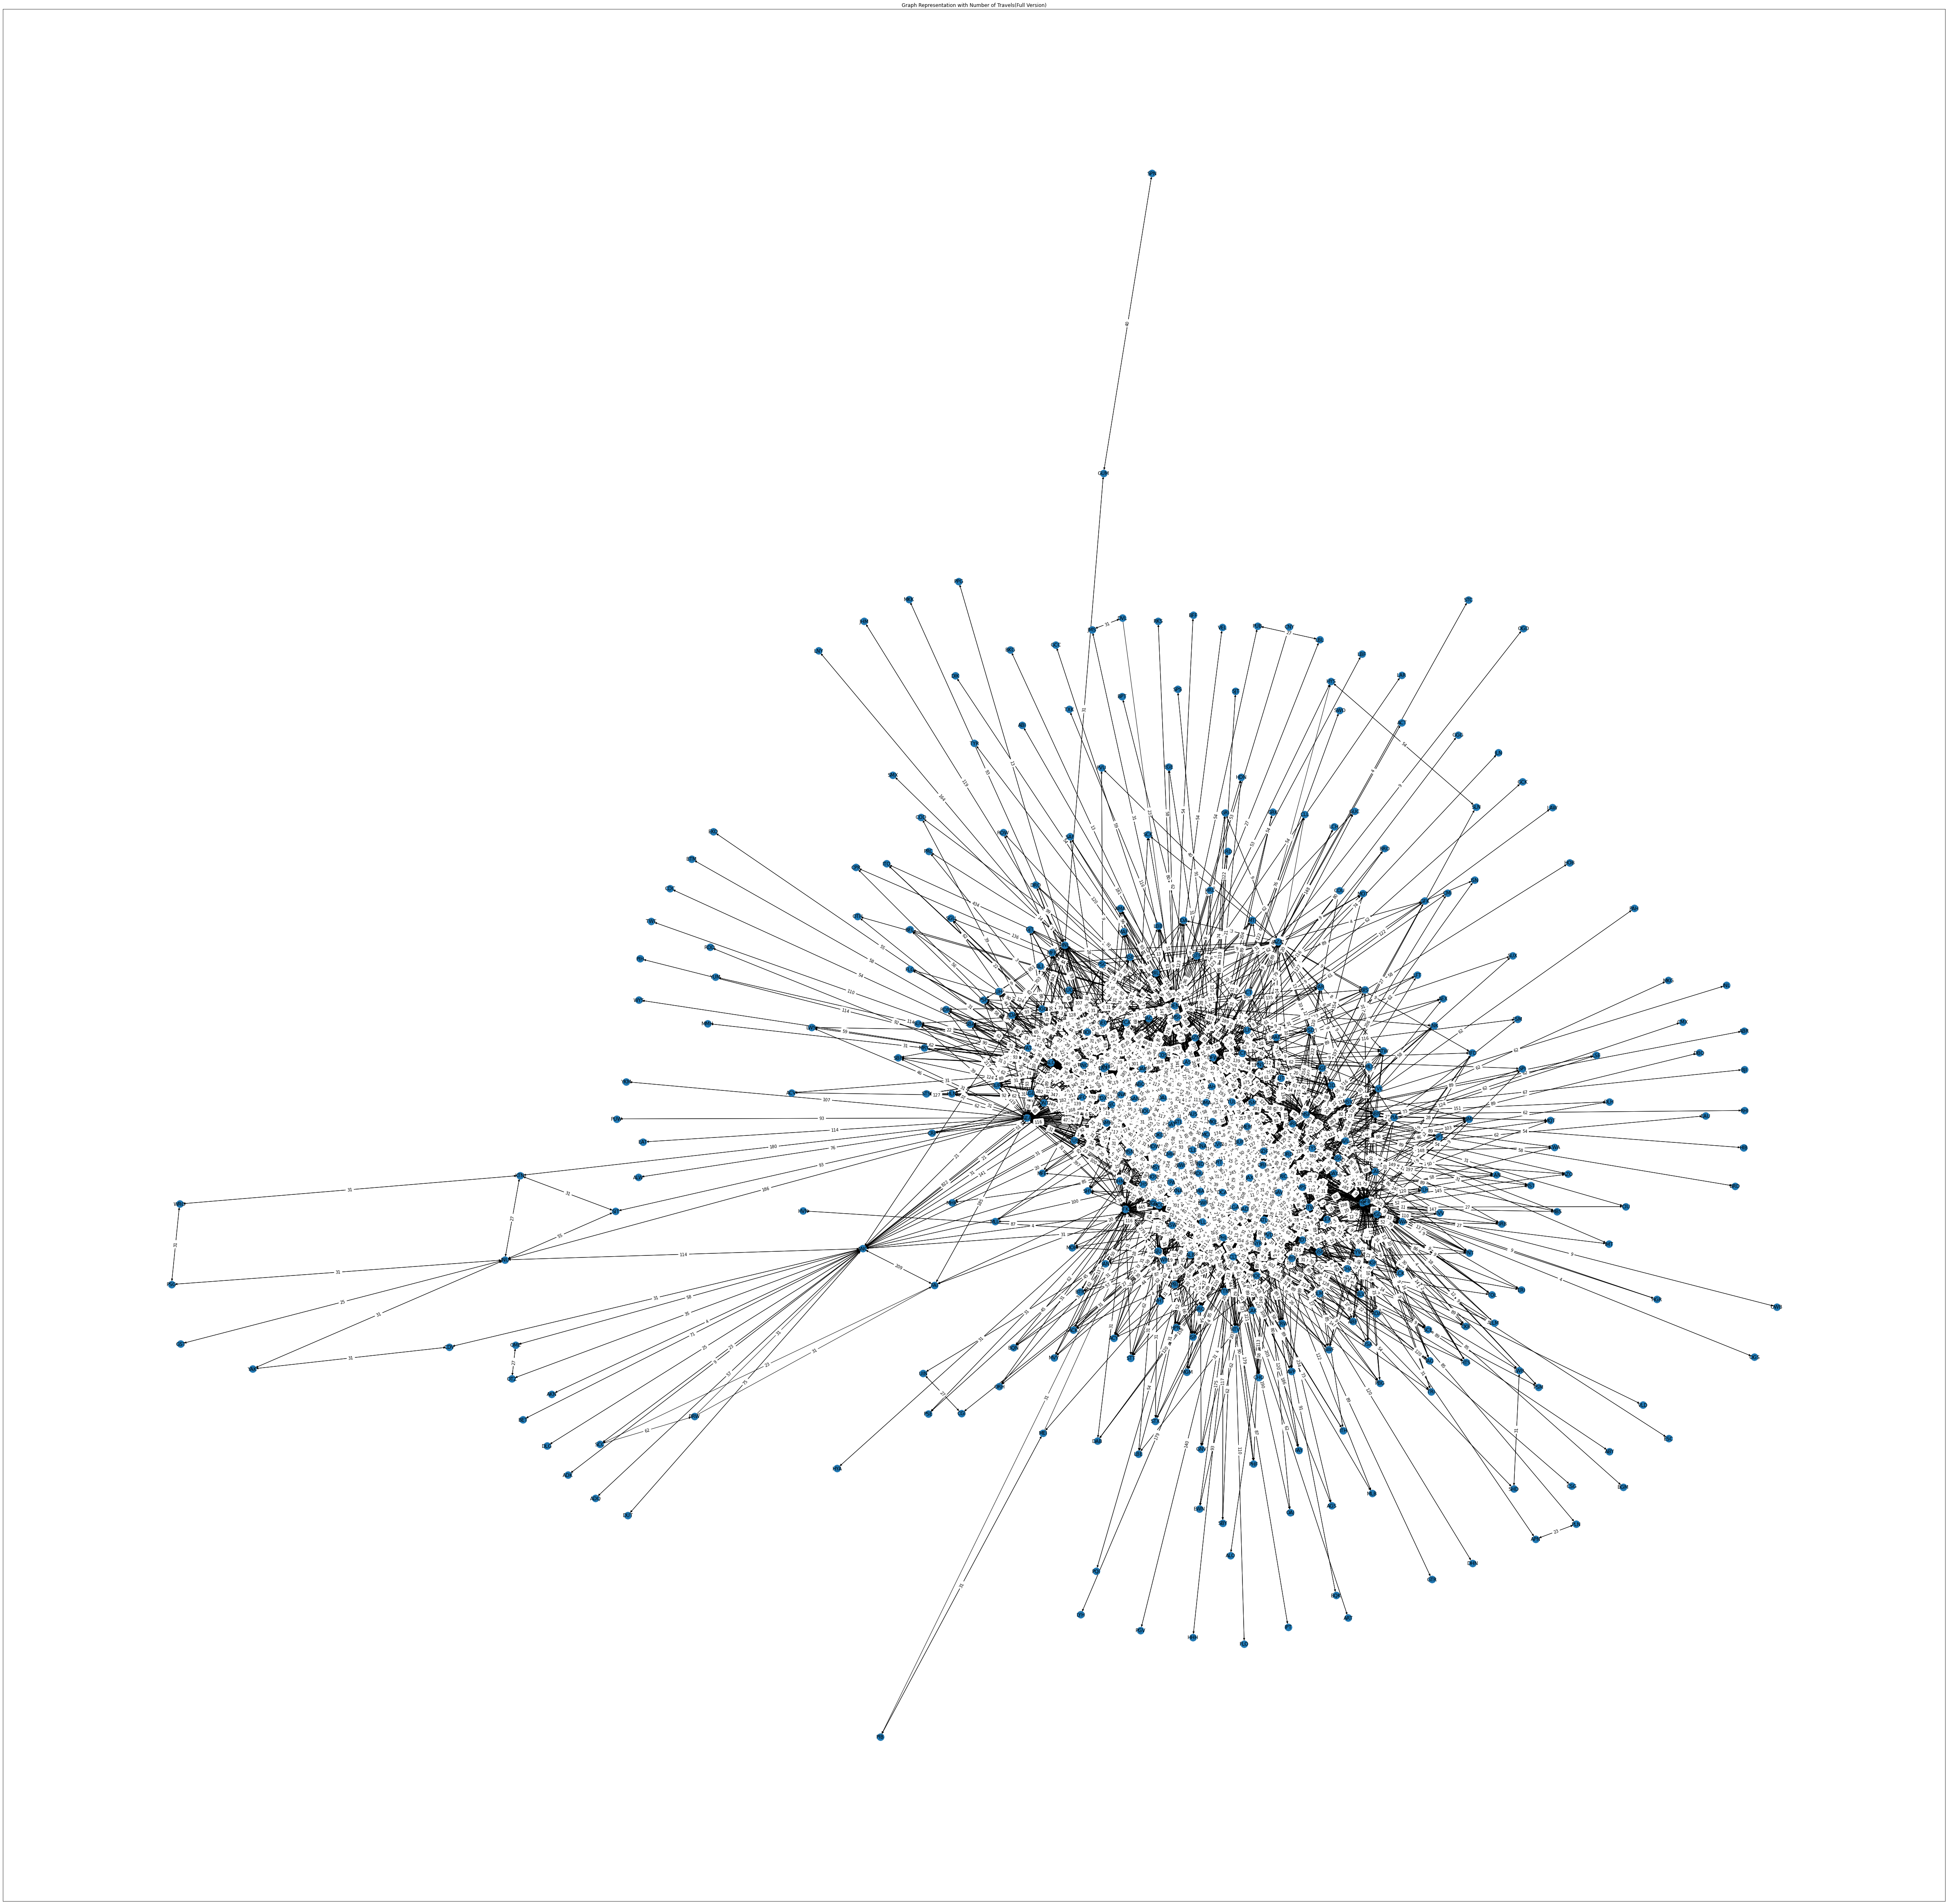

In [28]:
G3 = nx.from_pandas_edgelist(df2, "ORIGIN", "DEST", "NUM_TRAVEL", create_using=nx.DiGraph())

fig = plt.gcf()
fig.set_size_inches(85, 85)

pos3 = nx.spring_layout(G3)
nx.draw_networkx(G3, pos3, with_labels=True)
labels3 = nx.get_edge_attributes(G3, 'NUM_TRAVEL')
nx.draw_networkx_edge_labels(G3, pos3, edge_labels=labels3)
plt.title("Graph Representation with Number of Travels(Full Version)")
plt.show()

### Shortest distance 1 - Bellman Ford

In [54]:
def bellman_ford(graph, distance, start):
    for node in graph.nodes():
        if node in graph[start]:
            distance[node] = graph[start][node]['MEAN_ELAPSED_TIME']
        else:
            distance[node] = None
    distance[start] = 0
    for v in graph.nodes():
        for w in graph[v]:
            if distance[v] != None and (distance[w] == None or distance[v] + graph[v][w]['MEAN_ELAPSED_TIME'] < distance[w]):
                distance[w] = distance[v] + graph[v][w]['MEAN_ELAPSED_TIME']
    return distance

def get_shortest_distance(g, start, end):
    dist = {}
    distance = bellman_ford(g, dist, start)
    return distance[end]

start1 = 'IND'
end1 = 'HNL'
print("1. Time it takes from {} to {} is:".format(start1,end1), 
      get_shortest_distance(G2, start1, end1), 'minutes')

start2 = 'BOS'
end2 = 'HNL'
print("2. Time it takes from {} to {} is:".format(start2,end2), 
      get_shortest_distance(G2, start2, end2), 'minutes')

start3 = 'GEG'
end3 = 'ORH'
print("3. Time it takes from {} to {} is:".format(start3,end3), 
      get_shortest_distance(G2, start3, end3), 'minutes')

start4 = 'PBI'
end4 = 'LEX'
print("4. Time it takes from {} to {} is:".format(start4,end4), 
      get_shortest_distance(G2, start4, end4), 'minutes')

start5 = 'YKM'
end5 = 'JNU'
print("5. Time it takes from {} to {} is:".format(start5,end5), 
      get_shortest_distance(G2, start5, end5), 'minutes')

1. Time it takes from IND to HNL is: 594.92 minutes
2. Time it takes from BOS to HNL is: 704.78 minutes
3. Time it takes from GEG to ORH is: 415.06 minutes
4. Time it takes from PBI to LEX is: 185.6 minutes
5. Time it takes from YKM to JNU is: 196.3 minutes


### EDA 7 - Popularity

In [56]:
def get_df_for_in_out_bound(graph):
    inbound = {}
    outbound = {}
    for node in graph.nodes():
        inbound[node] = 0
        outbound[node] = 0
    for i in graph.nodes():
        for j in graph.nodes():
            if j in graph[i]:
                inbound[j] += graph[i][j]['NUM_TRAVEL']
                outbound[i] += graph[i][j]['NUM_TRAVEL']
    df_response = pd.DataFrame(columns = ['Airport', 'Inbound', 'Outbound'])
    for i in inbound.keys():
        current_in = inbound[i]
        current_out = outbound[i]
        row_df = pd.DataFrame([[i, current_in, current_out]], columns = ['Airport', 'Inbound', 'Outbound'])
        df_response = df_response.append(row_df)
    return df_response

df_in_out = get_df_for_in_out_bound(G3)
df_in_out = df_in_out.reset_index(drop=True)
df_in_out

Airport Inbound Outbound
0       ABE     514      514
1       ATL   35237    35225
2       CLT   21582    21580
3       DTW   15904    15902
4       FLL    7772     7774
..      ...     ...      ...
360     PUW      93       93
361     RDD      92       92
362     YKM     107      107
363     TWF     110      110
364     WYS      59       59

[365 rows x 3 columns]

In [60]:
df_in_out = df_in_out.sort_values(by='Inbound', ascending=False).reset_index(drop=True)
df_in_out
df_in_out.to_csv("../data/df_in_out.csv")

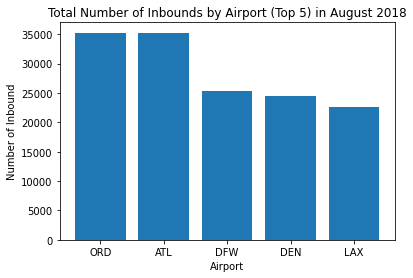

In [58]:
df_in_out_top5 = df_in_out.head(5)
plt.bar(df_in_out_top5['Airport'], height=df_in_out_top5['Inbound'])
plt.xlabel("Airport")
plt.ylabel("Number of Inbound")
plt.title("Total Number of Inbounds by Airport (Top 5) in August 2018")
plt.show()